In [1]:
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
%matplotlib inline

/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
multiplier = 20
min_tick = 0.25

In [3]:
periods = [10, 20, 40, 80, 160,] # 320] # number of periods for breakout rule
ema_fast = 80 # number of periods for moving average filter
sl_atr = 1 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
time_int = 30 # interval in minutes to be used to define volume candle

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

9916.21218117854

In [5]:
#vol_candles = group_by_time(contract, time_int)
vol_candles = group_by_volume(contract, avg_vol)
data = pd.DataFrame(vol_candles.close)
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()

In [6]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

In [7]:
def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).round(0)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
  

In [8]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

In [9]:
signals['value'] = signals['close'] * signals['signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

In [10]:
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, atr_periods)

In [11]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * sl_atr
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [12]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [13]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(12186.25, 9662.75, 21849.0)

In [14]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(8428, 6852, 0.5515706806282723)

In [15]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(74809.75, -52960.75, 1.4125508041332495)

In [16]:
pnl_m.sort_values().head(20)

label
5073    -97.00
5045    -76.50
5101    -71.25
22364   -64.50
5065    -52.25
15425   -49.75
12165   -48.75
5268    -47.00
5132    -46.25
15902   -46.00
6775    -45.25
15643   -45.00
15313   -43.75
14054   -43.25
5111    -43.00
5313    -42.50
22445   -42.50
14431   -42.25
15857   -42.00
5049    -41.75
Name: pnl, dtype: float64

In [17]:
pnl_p.sort_values(ascending=False).head(20)

label
14653    118.25
5068     111.25
21588     95.25
5044      70.75
22534     59.75
22616     58.50
13102     51.75
5204      51.75
22362     50.75
21243     49.50
13007     49.00
19496     48.75
20323     47.50
5048      45.75
5102      45.25
7849      45.25
12164     45.00
5308      44.75
14811     44.25
22433     43.75
Name: pnl, dtype: float64

In [18]:
signals['date'] = vol_candles['date']

In [19]:
signals.set_index('date', inplace=True)

In [20]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-08-31,NaN,0.00
2019-09-01,NaN,0.00
2019-09-02,7618.00,-32.25
2019-09-03,7614.50,3.50
2019-09-04,7697.25,30.75


In [21]:
daily.head()

,close,pnl
date,,
2017-05-25,5754.5,0.0
2017-05-26,NaN,0.0
2017-05-27,NaN,0.0
2017-05-28,NaN,0.0
2017-05-29,NaN,0.0


In [22]:
daily['dollars'] = 0
daily.iloc[0,2] = 25000

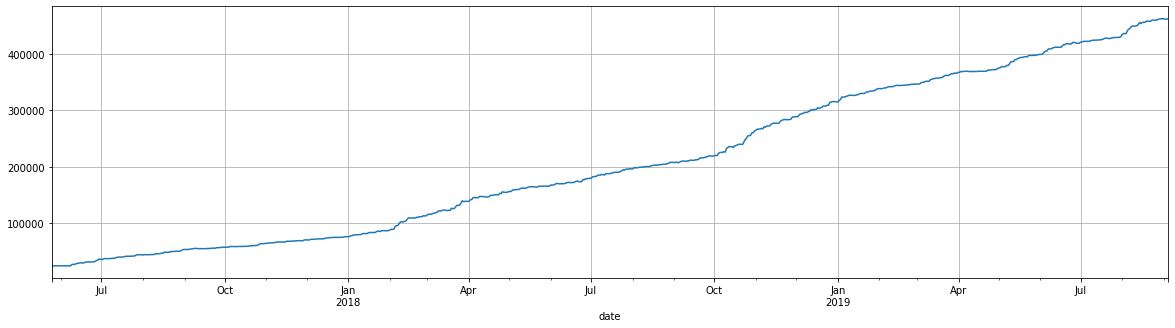

In [23]:
daily['dollars'] = 25000 + daily.pnl.cumsum() * multiplier
daily['return'] = daily.dollars.pct_change()
daily.dollars.plot(figsize=(20,5), grid=True);

In [24]:
perf_stats(daily['return'])

Annual return            1.416564
Cumulative returns      17.479200
Annual volatility        0.133769
Sharpe ratio             6.680648
Calmar ratio           113.563685
Stability                0.960225
Max drawdown            -0.012474
Omega ratio              9.649653
Sortino ratio           39.653697
Skew                          NaN
Kurtosis                      NaN
Tail ratio               5.469789
Daily value at risk     -0.013307
dtype: float64

In [25]:
number_of_trades

2481

In [26]:
spread = min_tick * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

17441.429999999997

In [27]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

832

In [28]:
trades_per_day = number_of_trades / days
trades_per_day

2.9819711538461537

In [29]:
pnl_in_dollars = pnl*multiplier

In [30]:
cost_of_trades / (pnl_in_dollars)

0.03991356583825346

In [31]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(0.8936615011805599, 0.13376869286039328)

In [32]:
mean/std

6.680647631903103

In [33]:
#daily.to_pickle('nq_return.pickle')